<a href="https://colab.research.google.com/github/whalid/Andriodapplication/blob/master/brain_tumor_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libaries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras



print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mapping datasets

In [ ]:
# Directories
train_dir = '/content/drive/MyDrive/third_dataset_of_brain_tumor/training'
val_dir = '/content/drive/MyDrive/third_dataset_of_brain_tumor/validation'
test_dir = '/content/drive/MyDrive/third_dataset_of_brain_tumor/testing'

# Parameters
batch_size = 64
img_height = 224
img_width = 224
num_classes = 2

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,

)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(train_ds)
print(val_ds)
print(test_ds)

Found 2400 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# #Augmntation
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create an ImageDataGenerator for augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#     shear_range=0.2,  # set range for random shear
#     zoom_range=0.2,  # set range for random zoom
#     horizontal_flip=True,  # randomly flip images horizontally
#     fill_mode='nearest'  # fill mode for filling in newly created pixels
# )

# # Augment the training dataset
# augmented_train_ds = train_ds.map(lambda x, y: (datagen.random_transform(x), y))

# # Combine augmented dataset with original training dataset
# augmented_train_ds = train_ds.concatenate(augmented_train_ds)

# # Get the cardinality of the final training dataset
# augmented_train_ds_size = tf.data.experimental.cardinality(augmented_train_ds).numpy()

# print("Total number of samples in the combined training dataset:", augmented_train_ds_size)

Normalize & One Hot encode the datasets

In [ ]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def one_hot_encode(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

train_ds = train_ds.map(normalize_img)
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(normalize_img)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(normalize_img)
test_ds = test_ds.map(one_hot_encode)
print(train_ds)
print(val_ds)
print(test_ds)
# Prefetch and cache datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [ ]:
# #Normalize Augmented Data
# augmented_train_ds = augmented_train_ds.map(normalize_img)
# augmented_train_ds = augmented_train_ds.map(one_hot_encode)

# # Prefetch and cache datasets
# AUTOTUNE = tf.data.AUTOTUNE

# augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=AUTOTUNE)


Printing avilable classes

In [ ]:
class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)


Class names: ['no', 'yes']


Display some sample images

(64, 2)


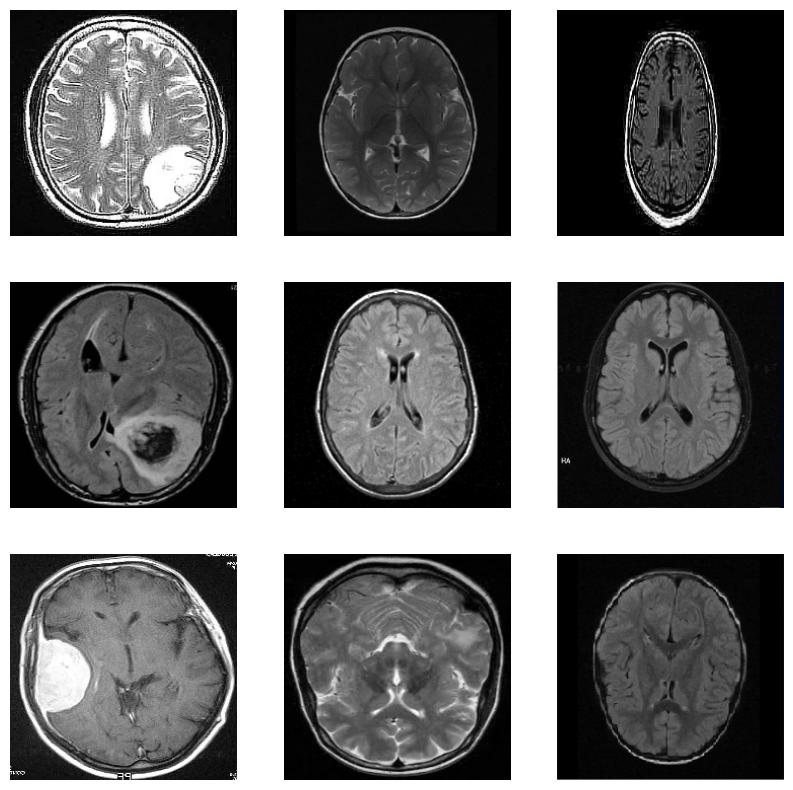

In [ ]:
def display_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            # plt.title(class_names[labels[i]])
            plt.axis("off")
            plt.savefig('/content/drive/MyDrive/Images/Dataset_sample.jpg')

images, labels = next(iter(train_ds))
# Display images from the train dataset
display_images(train_ds, class_names)
print(labels.shape)


Loading VGG16 pretrained model

Model: "custom_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv1 (Conv2D)               │ (None, 224, 224, 64)         │         1,792 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv2 (Conv2D)               │ (None, 224, 224, 64)         │        36,928 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_pool (MaxPooling2D)          │ (None, 112, 112, 64)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv1 (Conv2D)               │ (None, 112, 112, 128)        │        73,856 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv2 (Conv2D)               │ (None, 112, 112, 128)        │       147,584 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_pool (MaxPooling2D)          │ (None, 56, 56, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv1 (Conv2D)               │ (None, 56, 56, 256)          │       295,168 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv2 (Conv2D)               │ (None, 56, 56, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv3 (Conv2D)               │ (None, 56, 56, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_pool (MaxPooling2D)          │ (None, 28, 28, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv1 (Conv2D)               │ (None, 28, 28, 512)          │     1,180,160 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv2 (Conv2D)               │ (None, 28, 28, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv3 (Conv2D)               │ (None, 28, 28, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_pool (MaxPooling2D)          │ (None, 14, 14, 512)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv1 (Conv2D)               │ (None, 14, 14, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv2 (Conv2D)               │ (None, 14, 14, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv3 (Conv2D)               │ (None, 14, 14, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_pool (MaxPooling2D)          │ (None, 7, 7, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten_1 (Flatten)  

 Total params: 27,561,282 (105.14 MB)

 Trainable params: 12,846,594 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

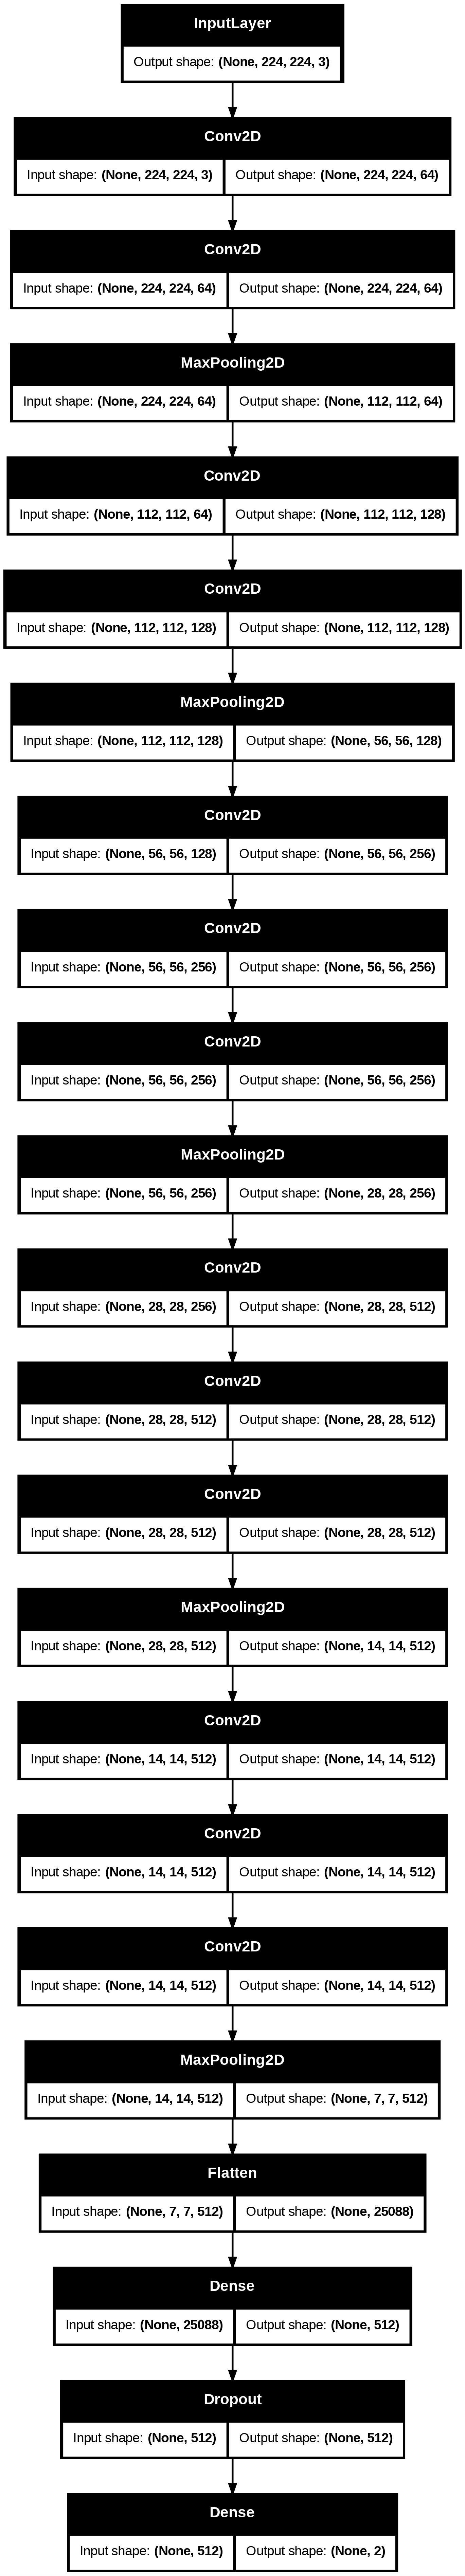

In [ ]:
# Load the VGG16 model with pretrained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=output, name='custom_classifier')

model.summary(show_trainable=True)
keras.utils.plot_model(model, to_file='/content/drive/MyDrive/Images/Pretrained_VGG16_arch.jpg', show_shapes=True)

Compile the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_name = 'Custom_vgg'
CHECKPOINT_DIR = '/content/drive/MyDrive/third_dataset_of_brain_tumor/checkpoints/'
model_path = CHECKPOINT_DIR + model_name + '/' + model_name + '.keras'


Transfer learning the pretrained VGG16 model & save weights in keras file

In [ ]:

my_callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, monitor = "val_loss", save_best_only = True),
       	keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10),
       	keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5, min_lr=1e-6, verbose=1)

]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=my_callbacks
)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1130s 30s/step - accuracy: 0.6587 - loss: 0.8864 - val_accuracy: 0.6667 - val_loss: 0.6319 - learning_rate: 1.0000e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - accuracy: 0.8905 - loss: 0.2624 - val_accuracy: 0.7900 - val_loss: 0.4449 - learning_rate: 1.0000e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step - accuracy: 0.9507 - loss: 0.1665 - val_accuracy: 0.8333 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 471ms/step - accuracy: 0.9628 - loss: 0.1175 - val_accuracy: 0.8567 - val_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.9740 - loss: 0.0983 - val_accuracy: 0.8367 - val_loss: 0.3562 - learning_rate: 1.0000e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.9824 - loss: 0.0737 - val_accuracy: 0.8000 - val_loss: 0.4277 - learning_rate: 1.0000e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/ste

Loading the trained model and get the test result

In [ ]:
model = tf.keras.models.load_model(model_path)
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 157s 31s/step - accuracy: 0.9502 - loss: 0.1302


[0.12528657913208008, 0.95333331823349]

In [ ]:
history = history.history
train_loss = history['loss']
train_acc = history['accuracy']

val_loss = history['val_loss']
val_acc = history['val_accuracy']

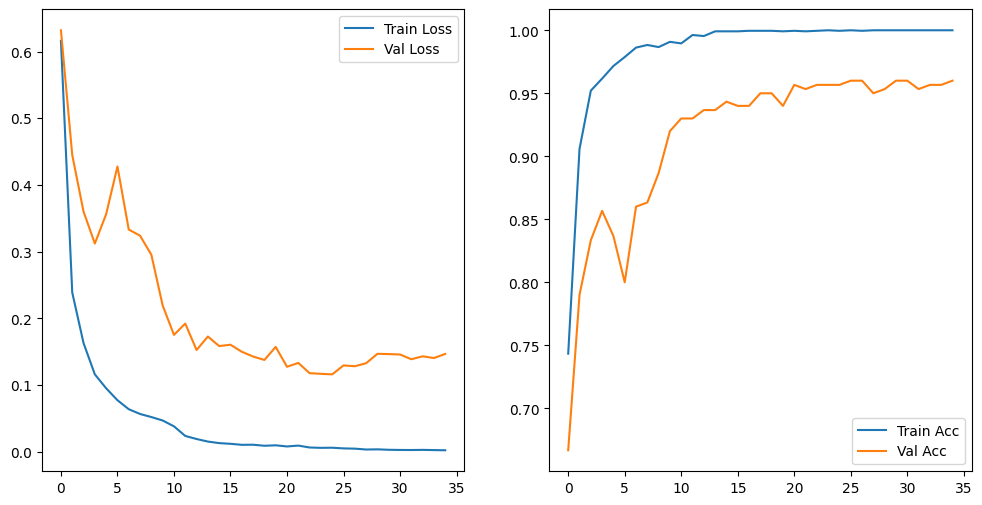

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label = 'Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/Images/PreTrainedVGGModel_history.jpg')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 223, 223, 64)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 223, 223, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 64)        │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 222, 222, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 110, 110, 32)        │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 110, 110, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 53, 53, 16)          │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 53, 53, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 16)          │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 52, 52, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,496,050 (17.15 MB)

 Trainable params: 4,495,570 (17.15 MB)

 Non-trainable params: 480 (1.88 KB)

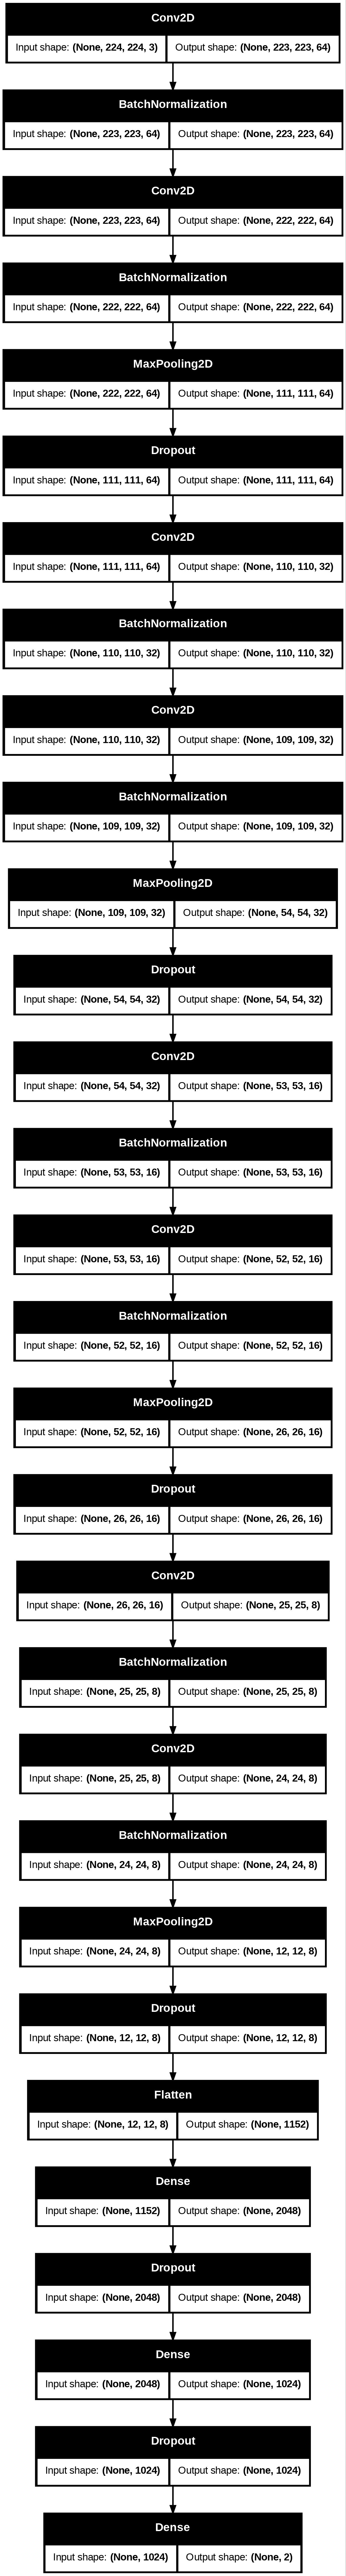

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization


custom_model = Sequential(
    [
        Conv2D(filters=64, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(2, 2), activation='relu', input_shape=(223, 223, 3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.1),

        Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(111, 111, 3)),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(110, 110, 3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.1),

        Conv2D(filters=16, kernel_size=(2, 2), activation='relu', input_shape=(55, 55, 3)),
        BatchNormalization(),
        Conv2D(filters=16, kernel_size=(2, 2), activation='relu', input_shape=(54, 54, 3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.1),

        Conv2D(filters=8, kernel_size=(2, 2), activation='relu', input_shape=(27, 27, 3)),
        BatchNormalization(),
        Conv2D(filters=8, kernel_size=(2, 2), activation='relu', input_shape=(26, 26, 3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.1),

        Flatten(),
        Dense(2048, activation='relu'),
        Dropout(0.1),
        Dense(1024, activation='relu'),
        Dropout(0.1),
        Dense(2, activation='softmax')

    ]
)


#custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_model.summary()
keras.utils.plot_model(custom_model, to_file='/content/drive/MyDrive/Images/Custom_model_arch.jpg', show_shapes=True)

In [ ]:
model_name = 'Custom_model'
CHECKPOINT_DIR = '/content/drive/MyDrive/third_dataset_of_brain_tumor/checkpoints/'
model_path = CHECKPOINT_DIR + model_name + '/' + model_name + '.keras'
my_callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, monitor = "val_loss", save_best_only = True),
       	keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10),
       	keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5, min_lr=1e-6, verbose=1)

]
custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_result = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=my_callbacks
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 545ms/step - accuracy: 0.9178 - loss: 0.2022 - val_accuracy: 0.6433 - val_loss: 0.7563 - learning_rate: 1.0000e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.9399 - loss: 0.1729 - val_accuracy: 0.7600 - val_loss: 0.5167 - learning_rate: 1.0000e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.9477 - loss: 0.1397 - val_accuracy: 0.7633 - val_loss: 0.5687 - learning_rate: 1.0000e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.9397 - loss: 0.1488 - val_accuracy: 0.8167 - val_loss: 0.4667 - learning_rate: 1.0000e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - accuracy: 0.9509 - loss: 0.1187 - val_accuracy: 0.8233 - val_loss: 0.5267 - learning_rate: 1.0000e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.9605 - loss: 0.0953 - val_accuracy: 0.7667 - val_loss: 0.6561 - learning_rate: 1.0000e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/ste

In [ ]:
custom_model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7938 - loss: 0.5115


[0.4782700538635254, 0.8033333420753479]

In [ ]:
history = custom_model_result.history
train_loss = history['loss']
train_acc = history['accuracy']

val_loss = history['val_loss']
val_acc = history['val_accuracy']

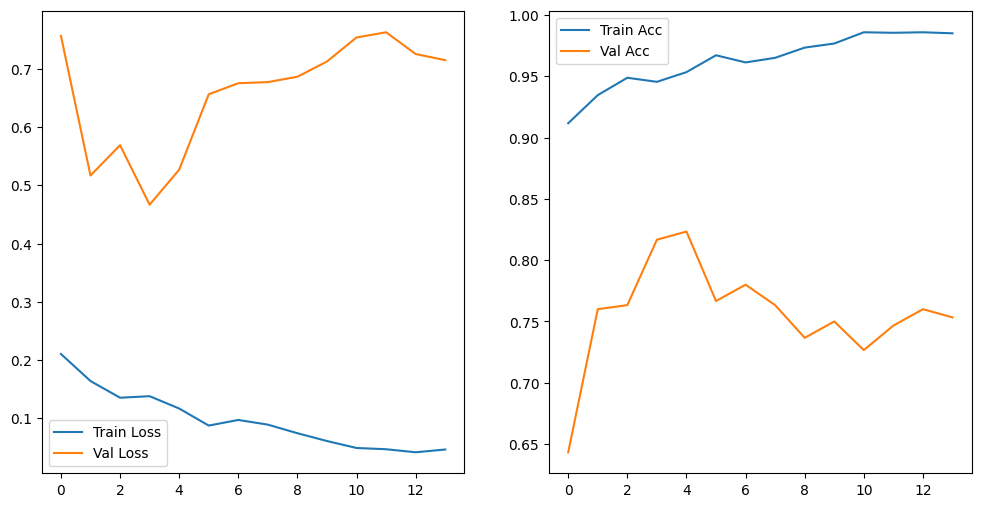

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label = 'Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/Images/Custom_Model_history.jpg')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


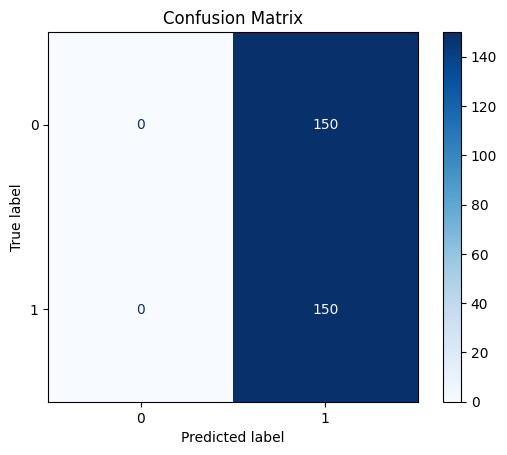

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert `y_true` and `y_pred` to integer labels if they are one-hot encoded
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred

# Generate confusion matrix and display
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
#plt.show()
plt.savefig('/content/drive/MyDrive/Images/Custom_Model_confusion_matrix.jpg')
